## JWST F1800W NGC3132 ERO

Data is setup in a subdirectory that is given in the filter variable below (i.e., "F560W"). Inside this directory, there should be 4 subdirectories called stage0, stage1, stage2, and stage3. The uncal (raw) fits files should be in the stage0 directory.

Author: Karl Gordon

Last modified: 18 Jul 2022

Based on JWebbinar notebooks by Bryan Hilbert, MIRI simulated notebooks by Mattia Libralato, input from various MIRI team members, and input from the jwst pipeline developers.

Uses custom code given in helpers subdirectory.

Extensively tested on MIRI ERO mosaics.

### Variables controling processing and display

In [1]:
filter = "F1800W"
fwhm = 5.2
basename = "jw0273300200"

crval = [151.75705520150103, -40.436433360520084]
# rotation = 112.
# crval = None
rotation = None

# shifts determine from previous runs with treakreg or with other filters
#   analysis using Analyze_teakreg_shifts.ipynb
#   run this notebook after running shortest wavelength dataset with tweakreg=True and align_to_gaia=True
#     and setting all the tile?_shifts to [0.0, 0.0]
#   use the resulting shifts here and set tweakreg=False and align_to_gaia=False
tile1_shifts = [0.17320409635878223, -0.06012765659475183]
tile2_shifts = [0.17320409635878223, -0.06012765659475183]
tweakreg = False
align_to_gaia = False

# only needed if multiple datasets combined that are taken separately (e.g., weeks apart)
matchbkg = False

# display range for uncalibrated images
drange_raw = [150., 600.]
# display range for calibrated images
drange_cal = [100., 600.]
dmap = "afmhot"  # same as ds9 bb

# specify the linearity file to use if default not desired
# linfile = ""
linfile = None

# specify the flat file to use if default not desired
flatfile = "RefFiles/flat_F1800W_kdg_10jun22.fits"

run_detector1 = True
run_image2 = True
run_image3 = True

In [2]:
import os
import glob
import copy

from astropy.io import ascii
from astropy.visualization import simple_norm

In [3]:
import astropy
print(astropy.__version__)

5.0.4


In [4]:
os.environ["CRDS_PATH"] = "/home/kgordon/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [6]:
# List of possible data quality flags
from jwst.datamodels import dqflags
from jwst import datamodels

from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

# custom helper routines
from helpers.jwst_helpers import show_image, overlay_catalog
from helpers.miri_helpers import miri_detector1, miri_image2, miri_image3
from helpers.miri_clean import fix_rateints_to_rate, shift_cal_wcs

In [7]:
import jwst
print(jwst.__version__)

1.6.2.dev4+g35d5e1d


In [8]:
import stcal
print(stcal.__version__)

1.0.1.dev2+g6262cda


In [9]:
# create stage directories if they do not exist
for k in range(4):
    cpath = f"./{filter}/stage{k}"
    if not os.path.exists(cpath):
        os.makedirs(cpath)

## CALWEBB_DETECTOR1

In [10]:
miri_uncal_files = glob.glob(f"./{filter}/stage0/*uncal.fits")
output_dir = f'./{filter}/stage1'
print(miri_uncal_files)

['./F1800W/stage0/jw02733002001_02107_00001_mirimage_uncal.fits', './F1800W/stage0/jw02733002002_02107_00008_mirimage_uncal.fits', './F1800W/stage0/jw02733002001_02107_00004_mirimage_uncal.fits', './F1800W/stage0/jw02733002002_02107_00003_mirimage_uncal.fits', './F1800W/stage0/jw02733002002_02107_00002_mirimage_uncal.fits', './F1800W/stage0/jw02733002002_02107_00007_mirimage_uncal.fits', './F1800W/stage0/jw02733002002_02107_00006_mirimage_uncal.fits', './F1800W/stage0/jw02733002001_02107_00003_mirimage_uncal.fits', './F1800W/stage0/jw02733002001_02107_00002_mirimage_uncal.fits', './F1800W/stage0/jw02733002001_02107_00007_mirimage_uncal.fits', './F1800W/stage0/jw02733002002_02107_00004_mirimage_uncal.fits', './F1800W/stage0/jw02733002001_02107_00006_mirimage_uncal.fits', './F1800W/stage0/jw02733002001_02107_00005_mirimage_uncal.fits', './F1800W/stage0/jw02733002002_02107_00005_mirimage_uncal.fits', './F1800W/stage0/jw02733002001_02107_00008_mirimage_uncal.fits', './F1800W/stage0/jw02733

In [11]:
if run_detector1:
    miri_detector1(miri_uncal_files, output_dir, linfile=linfile)

In [12]:
# fix the making of the rate images from the rateints images
#   needed for multiple integrations in regions near saturation
miri_rate_files = glob.glob(f"./{filter}/stage1/*ge_rate.fits")
for cfile in miri_rate_files:
    fix_rateints_to_rate(cfile)

In [13]:
# look at one of the images
miri_rate_files = glob.glob(f"./{filter}/stage1/*ge_fixed_rate.fits")
miri_rate = datamodels.open(miri_rate_files[0])
drange = drange_raw

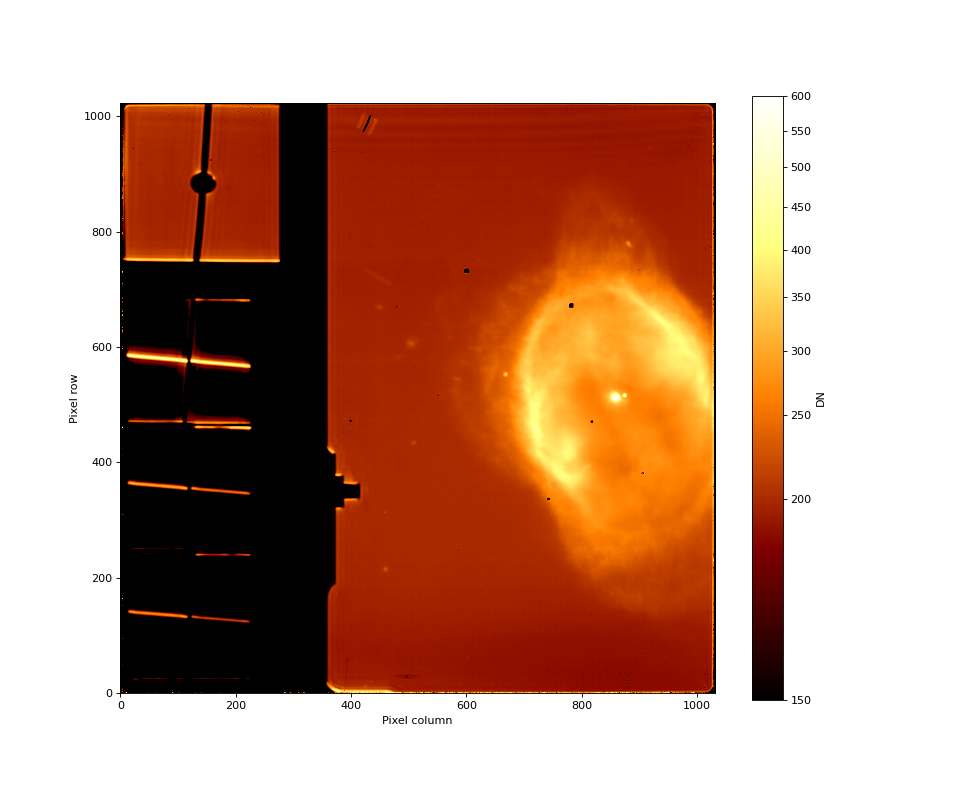

In [14]:
show_image(miri_rate.data, vmin=drange[0], vmax=drange[1], dmap=dmap)

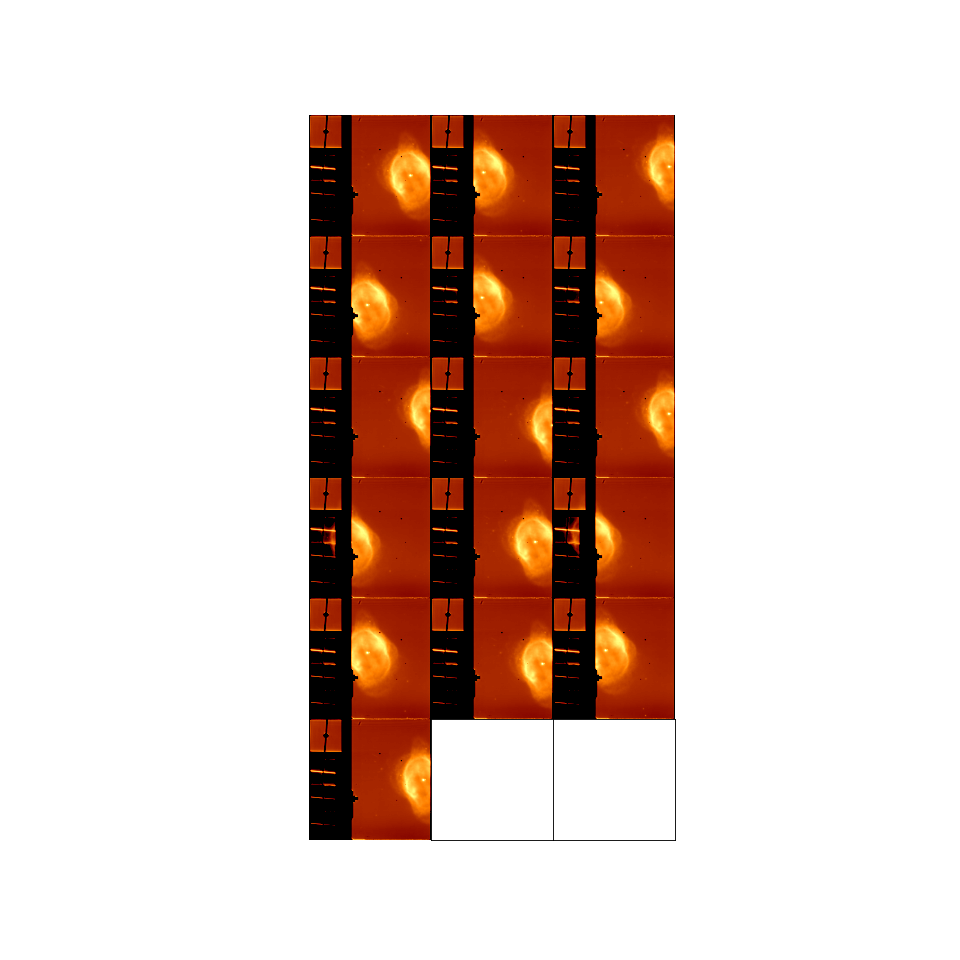

In [15]:
# display the images
fig = plt.figure(1, figsize=(12, 12))
ncols = len(miri_rate_files) // 3
grid = ImageGrid(fig, 111, nrows_ncols=(ncols+1, 3), axes_pad=0)

for i, cfile in enumerate(miri_rate_files):
    with datamodels.open(cfile) as miri_rate:
        cimage = miri_rate.data
        norm_data = simple_norm(cimage, "sqrt", min_cut=drange[0], max_cut=drange[1])
        grid[i].imshow(cimage, norm=norm_data, origin="lower", cmap=plt.get_cmap(dmap))
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])

## CALWEBB_IMAGE2

In [16]:
miri_rate_files = glob.glob(f"./{filter}/stage1/*ge_fixed_rate.fits")
output_dir = f'./{filter}/stage2'
print(miri_rate_files)

['./F1800W/stage1/jw02733002002_02107_00007_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002001_02107_00008_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002002_02107_00003_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002001_02107_00005_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002001_02107_00002_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002001_02107_00001_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002002_02107_00004_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002002_02107_00005_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002002_02107_00008_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002001_02107_00006_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002002_02107_00006_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002001_02107_00007_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002001_02107_00004_mirimage_fixed_rate.fits', './F1800W/stage1/jw02733002002_02107_00001_mirimage_fixed_rate.fits', './F1800W/stage1/jw

In [17]:
if run_image2:
    miri_image2(miri_rate_files, output_dir, flatfile=flatfile)

2022-07-20 13:00:08,059 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2022-07-20 13:00:08,060 - stpipe - CRITICAL - config: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': None, 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None, 'override_wfssbkg': None, 'override_wavelengthrange': None, 'class': ''}


2022-07-20 13:00:08,061 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-07-20 13:00:08,062 - stpipe - CRITICAL - config: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': None, 'sip_approx': True, 's

2022-07-20 13:00:09,202 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-20 13:00:09,203 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.
2022-07-20 13:00:09,203 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.
2022-07-20 13:00:09,205 - stpipe.Image2Pipeline - INFO - Override for FLAT reference file is '/astro/dust_kg3/kgordon/Commissioning/ERO/NGC3132/RefFiles/flat_F1800W_kdg_10jun22.fits'.
2022-07-20 13:00:09,207 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2022-07-20 13:00:09,207 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2022-07-20 13:00:09,207 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2022-07-20 13:00:09,208 - stpipe.Image2Pipeline - INFO 

2022-07-20 13:00:09,244 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2022-07-20 13:00:09,245 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-07-20 13:00:09,245 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw02733002001_02107_00005_mirimage_fixed_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2022-07-20 13:00:09,248 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits'.
2022-07-20 13:00:09,250 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2022-07-20 13:00:09,250 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2022-07-

2022-07-20 13:00:09,286 - stpipe.Image2Pipeline - INFO - Override for FLAT reference file is '/astro/dust_kg3/kgordon/Commissioning/ERO/NGC3132/RefFiles/flat_F1800W_kdg_10jun22.fits'.
2022-07-20 13:00:09,287 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2022-07-20 13:00:09,287 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2022-07-20 13:00:09,287 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2022-07-20 13:00:09,288 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2022-07-20 13:00:09,288 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-07-20 13:00:09,288 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2022-07-20 13:00:09,288 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2022-07-20 13:00:09,288 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/kgordo

2022-07-20 13:00:09,346 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits'.
2022-07-20 13:00:09,356 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2022-07-20 13:00:09,356 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2022-07-20 13:00:09,357 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2022-07-20 13:00:09,357 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2022-07-20 13:00:09,357 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf'.
2022-07-20 13:00:09,359 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-20 13:00:09,360 - stpipe.Image2Pipeline - INFO - Prefetch

2022-07-20 13:00:09,390 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-07-20 13:00:09,390 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2022-07-20 13:00:09,390 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2022-07-20 13:00:09,391 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits'.
2022-07-20 13:00:09,394 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-07-20 13:00:09,394 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2022-07-20 13:00:09,395 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2022-07-20 13:00:09,395 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2022-07-20 13:00:09,395 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-

2022-07-20 13:00:09,433 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2022-07-20 13:00:09,433 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf'.
2022-07-20 13:00:09,434 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-20 13:00:09,434 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.
2022-07-20 13:00:09,435 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.
2022-07-20 13:00:09,436 - stpipe.Image2Pipeline - INFO - Override for FLAT reference file is '/astro/dust_kg3/kgordon/Commissioning/ERO/NGC3132/RefFiles/flat_F1800W_kdg_10jun22.fits'.
2022-07-20 13:00:09,436 - stpipe.Image2Pipeline - INFO - Prefetch for FOR

2022-07-20 13:00:09,485 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-07-20 13:00:09,485 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2022-07-20 13:00:09,485 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2022-07-20 13:00:09,485 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2022-07-20 13:00:09,486 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-07-20 13:00:09,487 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...
2022-07-20 13:00:09,493 - stpipe.Image2Pipeline - INFO - Processing product ./F1800W/stage1/jw02733002002_02107_00007_mirimage_fixed
2022-07-20 13:00:09,494 - stpipe.Image2Pipeline - INFO - Working on input ./F1800W/stage1/jw02733002002_02107_00007_mirimage_fixed_rate.fits ...
2022-07-20 13:00:09,705 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1

2022-07-20 13:00:14,997 - stpipe.Image2Pipeline - INFO - Finished processing product ./F1800W/stage1/jw02733002002_02107_00007_mirimage_fixed
2022-07-20 13:00:14,998 - stpipe.Image2Pipeline - INFO - Processing product ./F1800W/stage1/jw02733002001_02107_00008_mirimage_fixed
2022-07-20 13:00:14,998 - stpipe.Image2Pipeline - INFO - Working on input ./F1800W/stage1/jw02733002001_02107_00008_mirimage_fixed_rate.fits ...
2022-07-20 13:00:15,188 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from jw02733002001_02107_00008_mirimage_fixed_rate.fits>,).
2022-07-20 13:00:15,189 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_

2022-07-20 13:00:20,595 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from jw02733002002_02107_00003_mirimage_fixed_rate.fits>,).
2022-07-20 13:00:20,597 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-07-20 13:00:20,788 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/kgordon/crds_cache/references/jwst

2022-07-20 13:00:26,166 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}
2022-07-20 13:00:26,247 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  151.731052467 -40.441512573 151.764873073 -40.459288078 151.788366386 -40.433458077 151.754714721 -40.415422420
2022-07-20 13:00:26,247 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  151.731052467 -40.441512573 151.764873073 -40.459288078 151.788366386 -40.433458077 151.754714721 -40.415422420
2022-07-20 13:00:26,247 - stpip

2022-07-20 13:00:31,629 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  151.730397596 -40.438858442 151.764216709 -40.456634121 151.787709325 -40.430804242 151.754059149 -40.412768411
2022-07-20 13:00:31,630 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  151.730397596 -40.438858442 151.764216709 -40.456634121 151.787709325 -40.430804242 151.754059149 -40.412768411
2022-07-20 13:00:31,630 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-07-20 13:00:31,696 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-07-20 13:00:31,850 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from jw02733002001_02107_00002_mirimage_fixed_rate.fits>,).
2022-07-20 13:00:31,851 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits

2022-07-20 13:00:37,064 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-07-20 13:00:37,130 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-07-20 13:00:37,285 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from jw02733002001_02107_00001_mirimage_fixed_rate.fits>,).
2022-07-20 13:00:37,286 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-07-20 13:00:37,372 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-20 13:00:37,373 - stpipe.

2022-07-20 13:00:42,803 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-20 13:00:42,804 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-20 13:00:42,804 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-20 13:00:42,810 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-20 13:00:42,916 - stpipe.Image2Pipeline.flat_field - WARNING - /user/kgordon/Python/jwst/jwst/flatfield/flat_field.py:219: RuntimeWarning: invalid value encountered in multiply
  science.var_flat = science.data ** 2 / flat_data_squared * flat_err ** 2

2022-07-20 13:00:42,930 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
20

2022-07-20 13:00:48,220 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-20 13:00:48,325 - stpipe.Image2Pipeline.flat_field - WARNING - /user/kgordon/Python/jwst/jwst/flatfield/flat_field.py:219: RuntimeWarning: invalid value encountered in multiply
  science.var_flat = science.data ** 2 / flat_data_squared * flat_err ** 2

2022-07-20 13:00:48,340 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-07-20 13:00:48,500 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw02733002002_02107_00005_mirimage_fixed_rate.fits>,).
2022-07-20 13:00:48,502 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_o

2022-07-20 13:00:53,994 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-07-20 13:00:54,158 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw02733002002_02107_00008_mirimage_fixed_rate.fits>,).
2022-07-20 13:00:54,159 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-07-20 13:00:54,181 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits
2022-07-20 13:00:54,182 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-07-20 13:00:

2022-07-20 13:00:59,644 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits
2022-07-20 13:00:59,644 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-07-20 13:00:59,722 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2022-07-20 13:00:59,722 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2022-07-20 13:00:59,723 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2022-07-20 13:00:59,723 - stpipe.Image2Pipeline.photom - INFO -  filter: F1800W
2022-07-20 13:00:59,763 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2022-07-20 13:00:59,765 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2022-07-20 13:00:59,765 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.
2022-07-20 13:00:59,766 - stpipe.Image2

2022-07-20 13:01:05,287 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2022-07-20 13:01:05,287 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2022-07-20 13:01:05,288 - stpipe.Image2Pipeline.photom - INFO -  filter: F1800W
2022-07-20 13:01:05,328 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2022-07-20 13:01:05,330 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2022-07-20 13:01:05,330 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.
2022-07-20 13:01:05,331 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.494384
2022-07-20 13:01:05,347 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-07-20 13:01:05,515 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from jw02733002002_02107_00006_mirimage_fixed_rate.fits>,).
2022-07-20 13:01:05,516 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre

2022-07-20 13:01:10,887 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.
2022-07-20 13:01:10,888 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.494384
2022-07-20 13:01:10,904 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-07-20 13:01:11,076 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from jw02733002001_02107_00007_mirimage_fixed_rate.fits>,).
2022-07-20 13:01:11,077 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixe

2022-07-20 13:01:16,708 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': False, 'allowed_memory': None}
2022-07-20 13:01:16,732 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits
2022-07-20 13:01:16,873 - stpipe.Image2Pipeline.resample - INFO - Resampling science data
2022-07-20 13:01:17,354 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-20 13:01:17,675 - stpip

2022-07-20 13:01:22,316 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits
2022-07-20 13:01:22,458 - stpipe.Image2Pipeline.resample - INFO - Resampling science data
2022-07-20 13:01:22,934 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-20 13:01:23,256 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise
2022-07-20 13:01:23,733 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-20 13:01:24,069 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson
2022-07-20 13:01:24,549 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-20 13:01:24,876 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-07-20 13:01:25,354 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-20 13:01:25,698 - stpipe.Image2Pipeline.resample 

2022-07-20 13:01:29,311 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-20 13:01:29,640 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson
2022-07-20 13:01:30,122 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-20 13:01:30,449 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-07-20 13:01:30,929 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-20 13:01:31,276 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  151.727299707 -40.437767466 151.761158295 -40.455701250 151.784942756 -40.429675776 151.751090926 -40.411748931
2022-07-20 13:01:31,930 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./F1800W/stage2/jw02733002001_02107_00003_mirimage_fixed_i2d.fits
2022-07-20 13:01:31,930 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2022-07-20 13:01:31,931 - stpipe.Image2Pipeline - INFO - Finishe

2022-07-20 13:01:36,841 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  151.717785497 -40.452238835 151.751648971 -40.470175252 151.775442043 -40.444151624 151.741585329 -40.426222150
2022-07-20 13:01:37,525 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./F1800W/stage2/jw02733002002_02107_00002_mirimage_fixed_i2d.fits
2022-07-20 13:01:37,525 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2022-07-20 13:01:37,526 - stpipe.Image2Pipeline - INFO - Finished processing product ./F1800W/stage1/jw02733002002_02107_00002_mirimage_fixed
2022-07-20 13:01:37,527 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2
2022-07-20 13:01:37,527 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0932.pmap
2022-07-20 13:01:37,528 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0932.pmap
2022-07-20 13:01:37,528 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0932.pmap
2022-07-20 13:01:37,528 - stpipe.Im

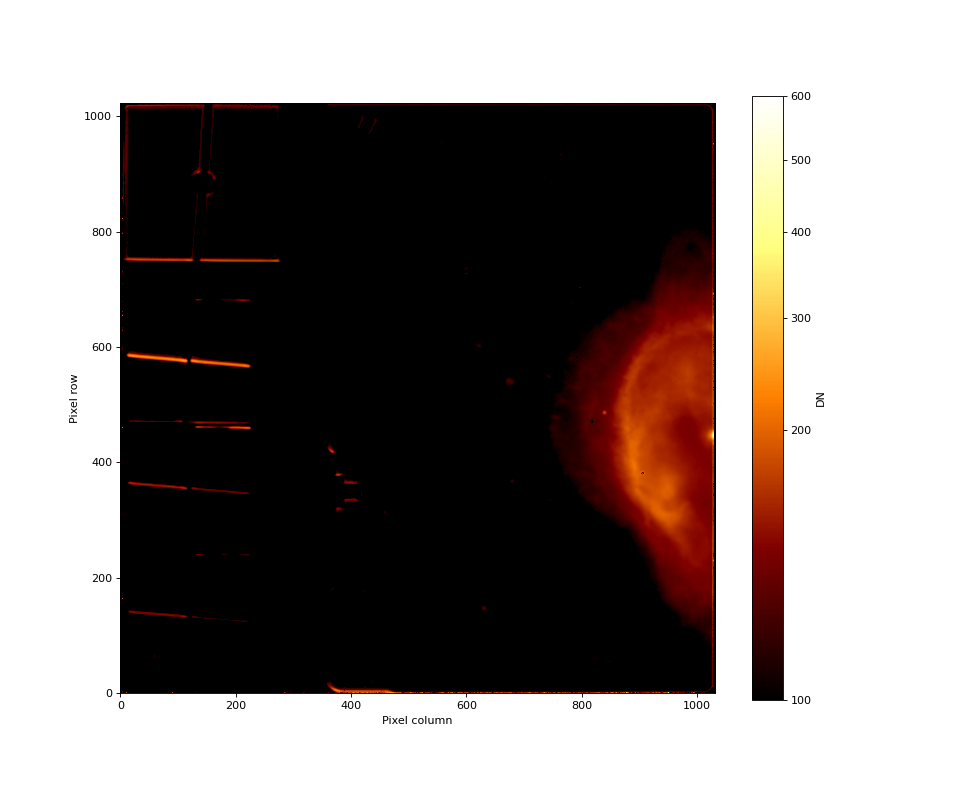

In [18]:
drange = drange_cal
# look at one of the images
miri_cal_files = glob.glob(f"./{filter}/stage2/*ge_fixed_cal.fits")
miri_cal = datamodels.open(miri_cal_files[0])
show_image(miri_cal.data, vmin=drange[0], vmax=drange[1], dmap=dmap)

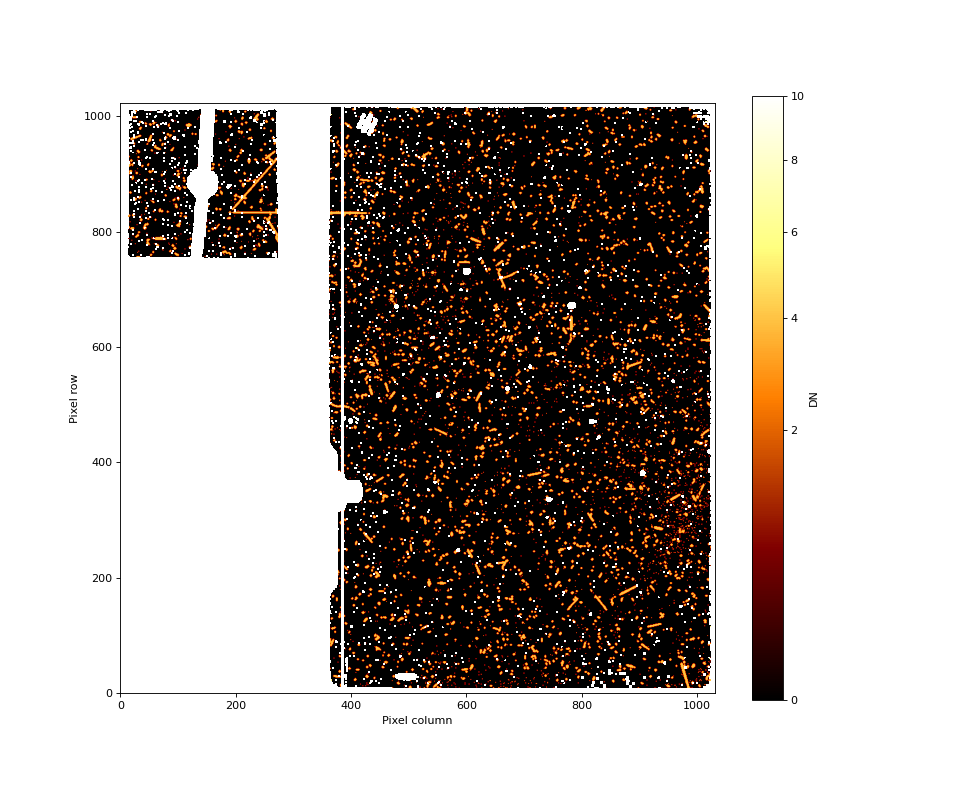

In [19]:
show_image(miri_cal.dq, 0, 10, dmap=dmap)

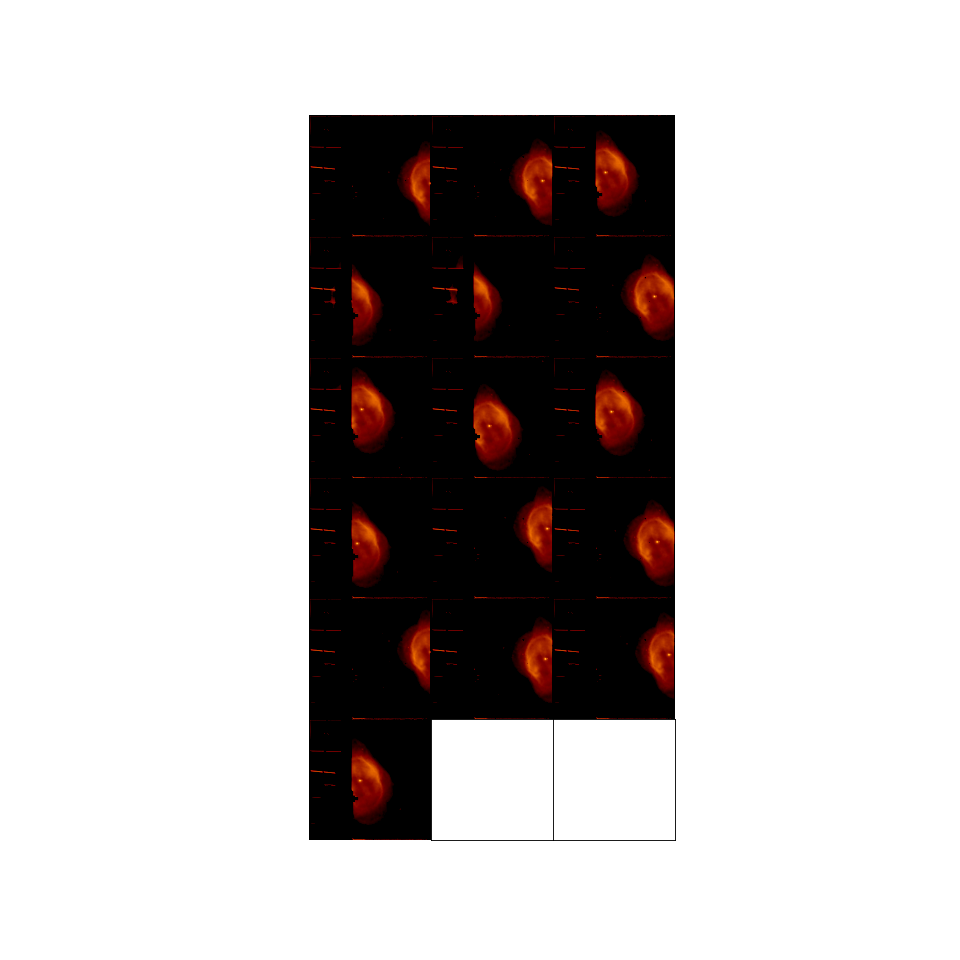

In [20]:
# display the images
fig = plt.figure(1, figsize=(12, 12))
ncols = len(miri_cal_files) // 3
grid = ImageGrid(fig, 111, nrows_ncols=(ncols+1, 3), axes_pad=0)

for i, cfile in enumerate(miri_cal_files):
    with datamodels.open(cfile) as miri_cal:
        cimage = miri_cal.data
        norm_data = simple_norm(cimage, "sqrt", min_cut=drange[0], max_cut=drange[1])
        grid[i].imshow(cimage, norm=norm_data, origin="lower", cmap=plt.get_cmap(dmap))
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])

## CALWEBB_IMAGE3

In [21]:
# update the WCS for mosaic tile 1
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}1*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile1_shifts)

# update the WCS for mosaic tile 2
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}2*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile2_shifts)

In [22]:
miri_cal_files = glob.glob(f"./{filter}/stage2/j*ge_fixed_wcs_cal.fits")
output_dir = f"./{filter}/stage3/"
print(miri_cal_files)

if rotation is not None:
    miri_asn_name = f'miri_{filter}_stage3_fixedrot_asn'
else: 
    miri_asn_name = f'miri_{filter}_stage3_asn'
miri_asn = asn_from_list.asn_from_list(miri_cal_files, rule=DMS_Level3_Base, product_name=miri_asn_name)

miri_asn_file = f'{miri_asn_name}.json'
with open(miri_asn_file, 'w') as outfile:
    name, serialized = miri_asn.dump(format='json')
    outfile.write(serialized)
    
print(miri_asn_file)

['./F1800W/stage2/jw02733002001_02107_00001_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002002_02107_00001_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002002_02107_00008_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002002_02107_00003_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002002_02107_00004_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002002_02107_00007_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002001_02107_00005_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002002_02107_00006_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002001_02107_00007_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002001_02107_00008_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002001_02107_00003_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002001_02107_00002_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002001_02107_00006_mirimage_fixed_wcs_cal.fits', './F1800W/stage2/jw02733002002_02107_00005_mirimag

In [23]:
if run_image3:
    miri_image3(miri_asn_file, output_dir, fwhm=fwhm, matchbkg=matchbkg, 
                crval=crval, rotation=rotation, 
                tweakreg=tweakreg, align_to_gaia=align_to_gaia)

2022-07-20 13:02:16,925 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-07-20 13:02:16,926 - stpipe - CRITICAL - config: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': None, 'class': ''}


2022-07-20 13:02:16,927 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-07-20 13:02:16,928 - stpipe - CRITICAL - config: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': None, 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_re

2022-07-20 13:02:17,361 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-20 13:02:17,362 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...
2022-07-20 13:02:20,614 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).
2022-07-20 13:02:20,616 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 5.2, 'snr_threshold': 5, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 5.0, 'use2dhist': True, 'separation': 1.0, 'tolerance': 0.7, 'xoffset': 

2022-07-20 13:02:52,866 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 13902 (1.32%)
2022-07-20 13:02:52,939 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 7135 (0.68%)
2022-07-20 13:02:53,011 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 22112 (2.09%)
2022-07-20 13:02:53,085 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 6320 (0.60%)
2022-07-20 13:02:53,158 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 13372 (1.27%)
2022-07-20 13:02:53,231 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 27228 (2.58%)
2022-07-20 13:02:53,304 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 7861 (0.74%)
2022-07-20 13:02:53,376 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 6083 (0.58%)
2022-07-20 13:02:53,447 - stpipe.Ima

2022-07-20 13:03:42,293 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1173, 1749)
2022-07-20 13:03:43,225 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1173, 1749)
2022-07-20 13:03:44,155 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1173, 1749)
2022-07-20 13:03:45,077 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1173, 1749)
2022-07-20 13:03:45,403 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson
2022-07-20 13:03:46,011 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1173, 1749)
2022-07-20 13:03:46,948 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1173, 1749)
2022-07-20 13:03:47,887 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1173, 1749)
2022-07-20 13:03:48,826 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1173, 1749)
2022-07-20 13:03:49,764 - stpipe.Image3Pipeline.resample - INFO

In [24]:
# Look at the resulting mosaic image
miri_mosaic_file = output_dir + miri_asn_name + '_i2d.fits'
miri_catalog_file = output_dir + miri_asn_name + '_cat.ecsv'

In [25]:
# Open the mosaic image
miri_mosaic = datamodels.open(miri_mosaic_file)

In [26]:
# Read in the source catalog
miri_source_cat = ascii.read(miri_catalog_file)

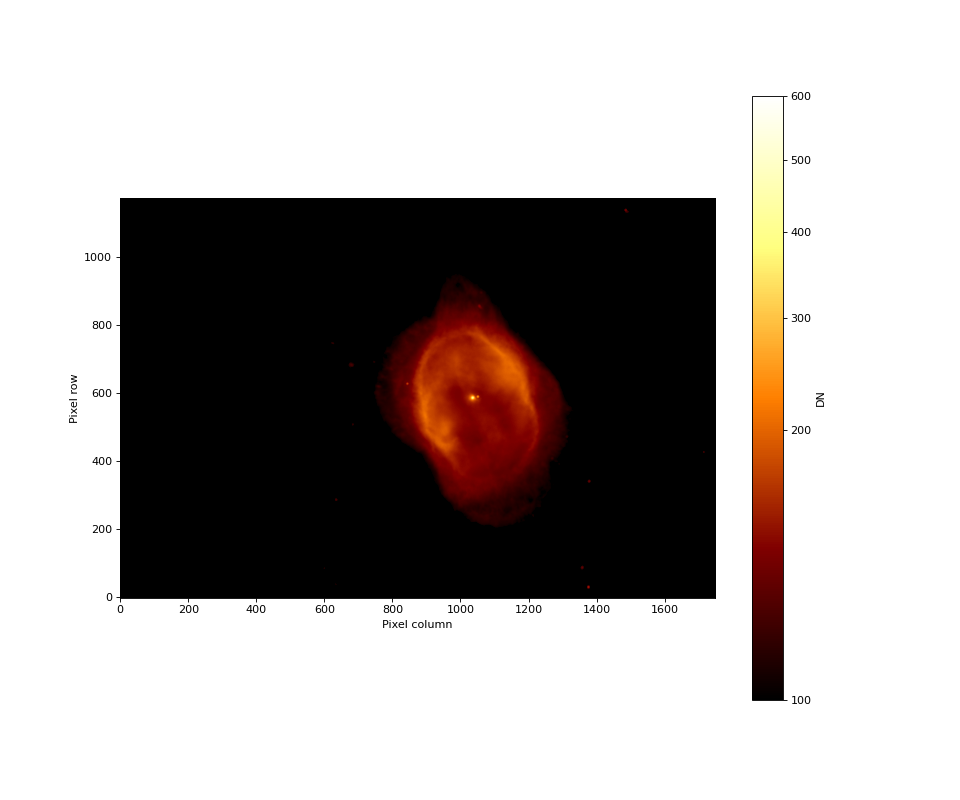

In [27]:
# Look at the mosaic
show_image(miri_mosaic.data, vmin=drange[0], vmax=drange[1], dmap=dmap)

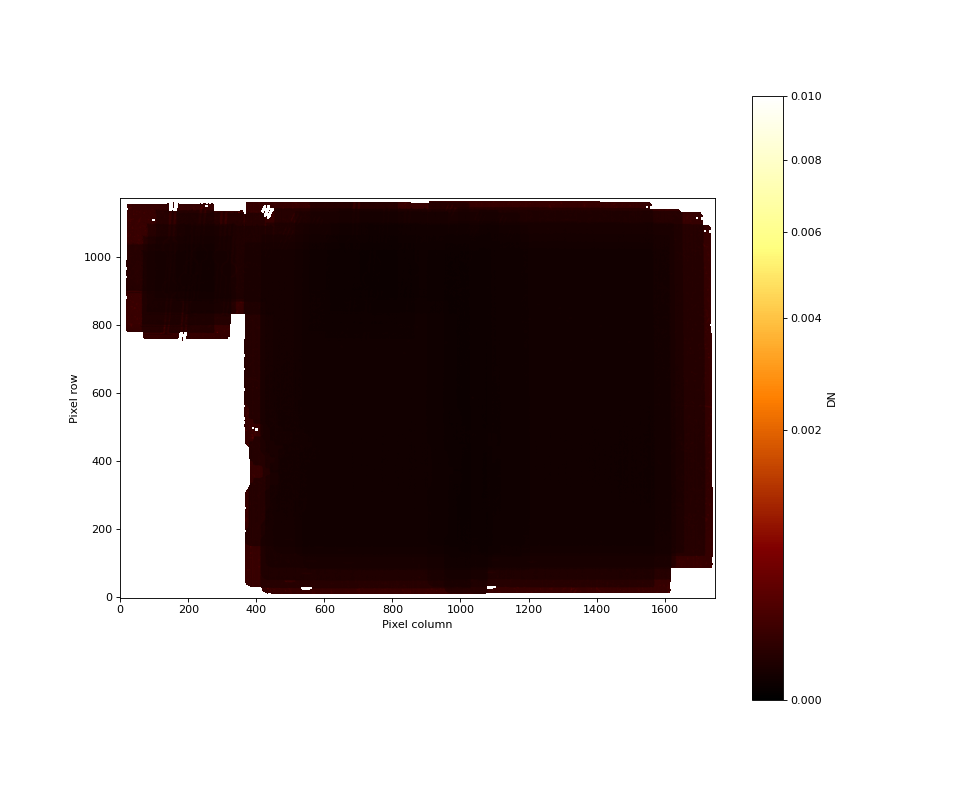

In [28]:
# Look at the mosaic data read noise uncertainties (i.e., coverage map)
show_image(miri_mosaic.var_rnoise, vmin=0.0, vmax=0.01, dmap=dmap)

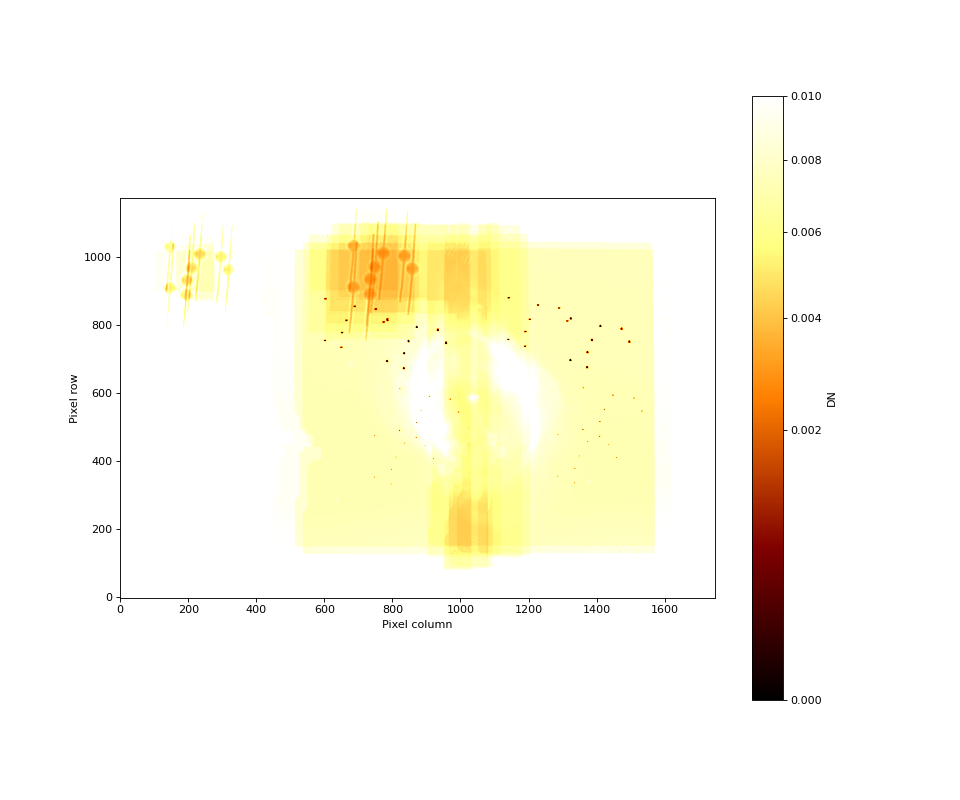

In [29]:
# Look at the mosaic data poisson uncertainties
show_image(miri_mosaic.var_poisson, vmin=0, vmax=0.01, dmap=dmap)

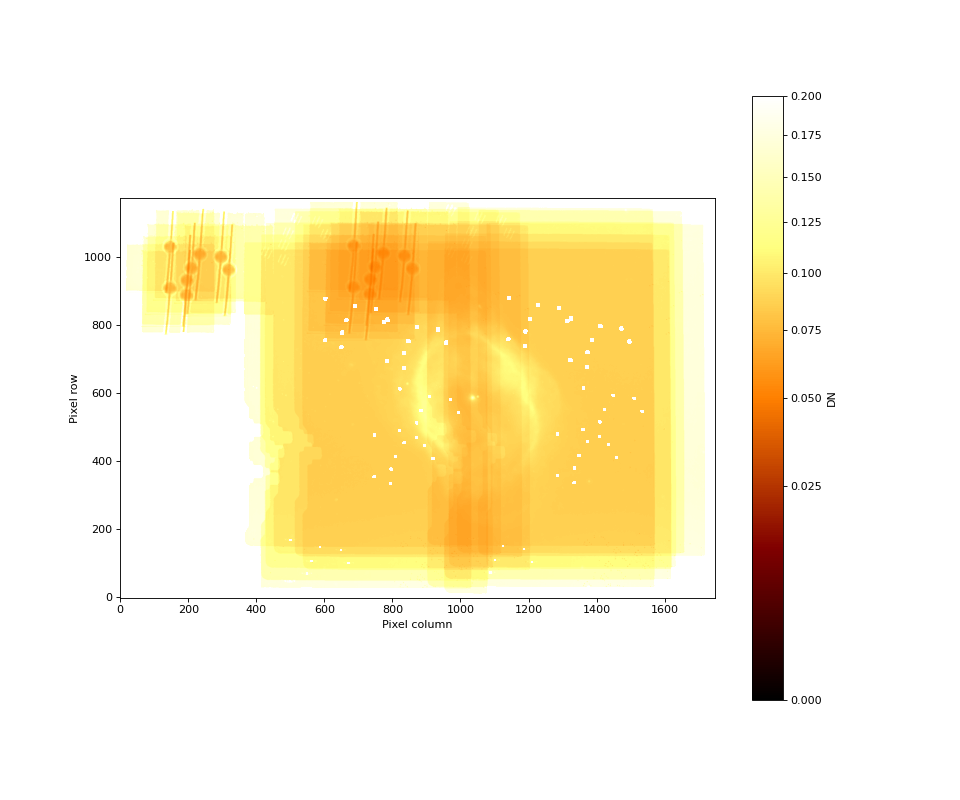

In [30]:
# Look at the mosaic total data uncertainties
show_image(miri_mosaic.err, vmin=0, vmax=0.2, dmap=dmap)

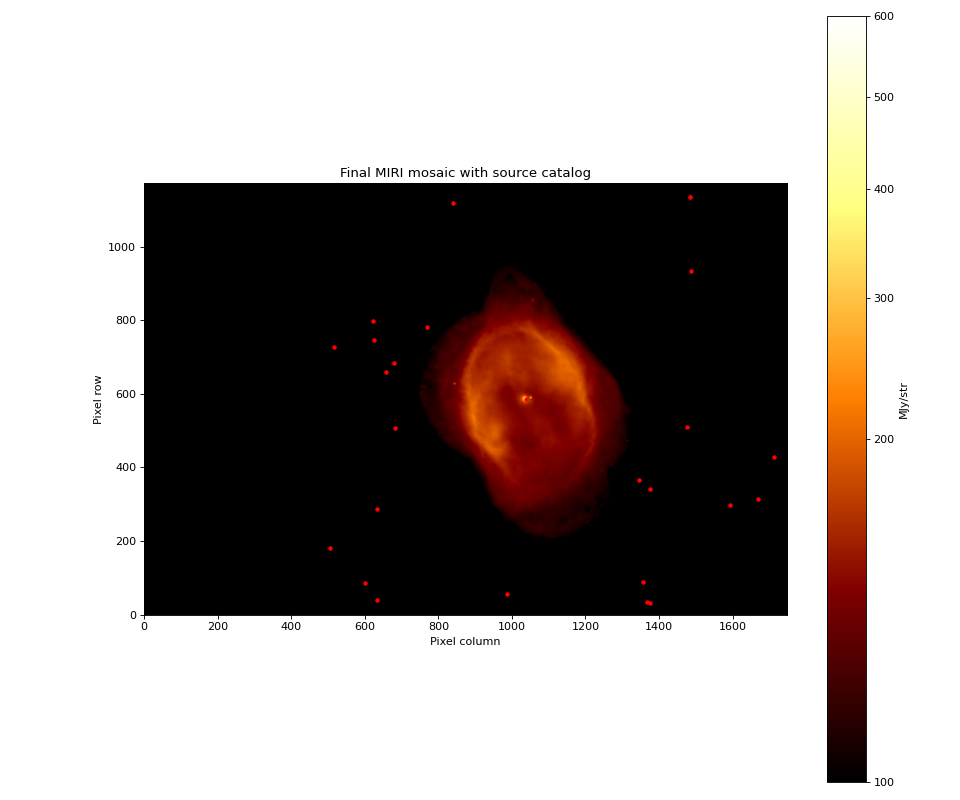

In [31]:
# Show the catalog sources on the mosaic
overlay_catalog(miri_mosaic.data, miri_source_cat, flux_limit=5e-7, vmin=drange[0], vmax=drange[1],
                title='Final MIRI mosaic with source catalog', dmap=dmap)